# WGAN - Wasserstein GAN

## Synthetic tabular data leveraging WGAN

Well, GANs are a particular kind of networks that are mainly trying to learn the probability distribution of a given dataset - and for this particular task, probability density jumps right away into our minds. If the real data distribution Pr admits a density and Pθ is the distribution of the parametrized density Pθ, then, symptotically, this amounts to minimizing the Kullback-Leibler divergence KL(PrkPθ).

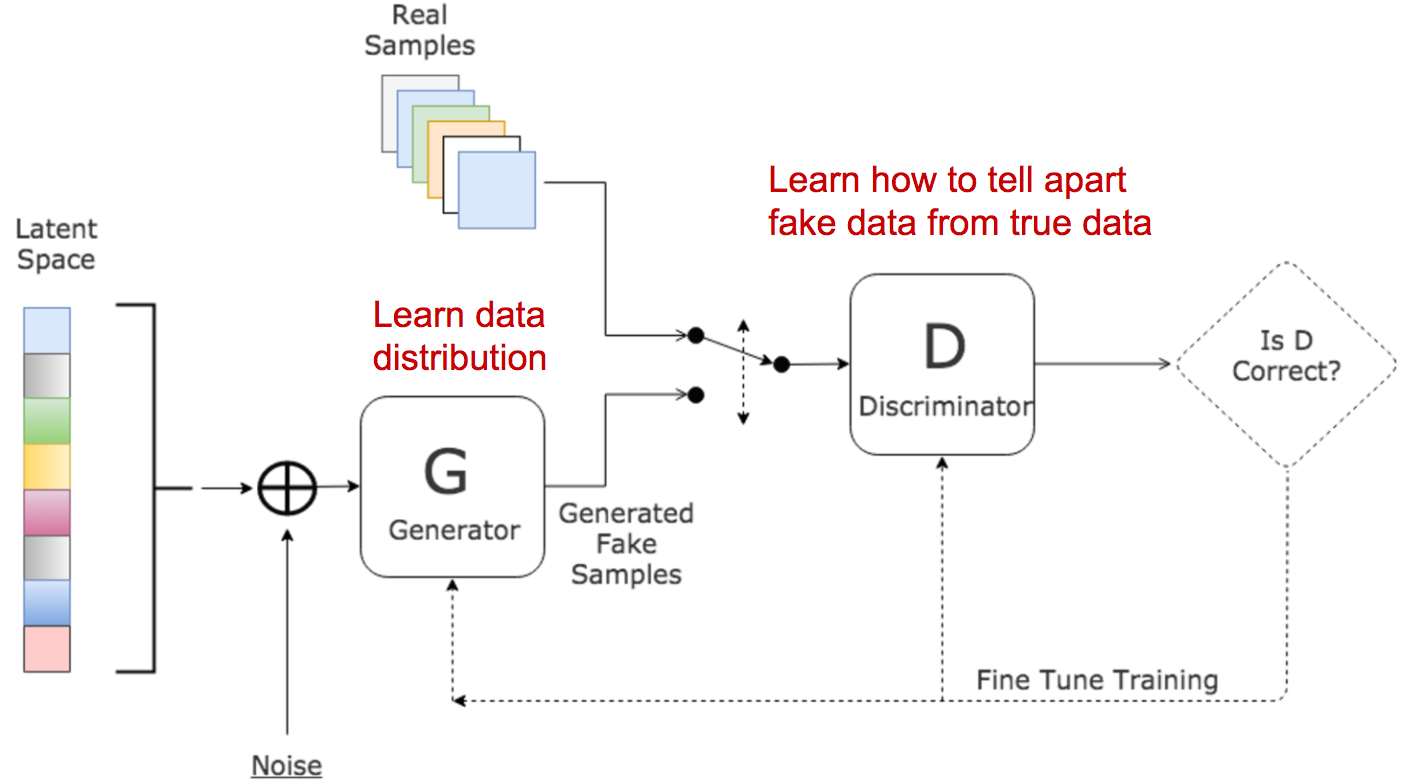
Fig.1 - Architecture of a generative adversarial network. (Image source: www.kdnuggets.com/2017/01/generative-…-learning.html)

But for this to make sense, we need the model density Pθ to exist. But this is not always the case, and in some cases it might be the situation where we deal with a KL distance not defined or simply infinite.


In a nutshell, the Wasserstein GAN, is an extension of the called Vanilla GANs, so what do they bring new? 



## The benefits

Wasserstein GAN was introduced by Martin Arjovsky and I'll leave it here the article the concept of using Earth-Mover distance as the loss function.

- [WGAN article](https://arxiv.org/pdf/1701.07875.pdf)

As I've mentioned WGAN introduces the concept of a critic, instead of discriminator, as this network scores the realness and fakeness of the given events. This change of concept was motivated by the argument that the generator should seek a minimization of the distance between the generated data and the one observed. This new concept, brings, off course, a few benefits: 

- The training stability of a WGAN is more stable when compared to, for example, VanillaGAN
- Less sensitive to model architecture selection (Generator and Critic choice)
- Less sensitive and impacted by the hyperparameters choice - although this is still very important to achieve good results.
- Most importantly, finally we can correlate the loss of the critic with the overall quality of the generated events.

### Why Wasserstein distance it is better than KL or JS divergence?

Very simple, and I kinda have covered it already - even if we are dealing with two distributions that are located in lower dimensional manifolds without overlaps, Wasserstein distance is still able to provide a meaningfull and smooth representation of the distance in-between. And that is what makes such a good bet to use this distance as a GAN loss function.

And without further a do, let's jump into the implementation!

## The implementation

#### The main differences between VanillaGAN and WGAN

These are the following changes that we will be undertaken in order to "transform" a VanillaGAN into a WGAN:

- After every gradient update on the critic function, clamp the weights to a small fixed range, [−c,c] -> This is the way we have to enforce the Lipschitz constraint.
- Use a new loss function derived from the Wasserstein distance.
- I suggest to go for RMSProp optimizer on the critic, rather than a momento based optimizer as it can cause instability.

In [ ]:
import numpy as np

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras import Model, constraints

In [ ]:
# Let's start by defining the main components of our network - The Discriminator and the Critic (Discriminator)

#The Generator
class Generator(tf.keras.Model):
    def __init__(self, batch_size):
        self.batch_size = batch_size

    def build_model(self, input_shape, dim, data_dim):
        input = Input(shape=input_shape, batch_size=self.batch_size)
        x = Dense(dim, activation='relu')(input)
        x = Dense(dim * 2, activation='relu')(x)
        x = Dense(dim * 4, activation='relu')(x)
        x = Dense(data_dim)(x)
        return Model(inputs=input, outputs=x)

In [ ]:
generator = Generator(batch_size=128).build_model((80, 1000), 126, 25)

generator.summary()

This generator is pretty simple. Here I've decided to go for a Dense Network with 4 Layers and Relu as the activation function

In [ ]:
#The Critic or Discriminator
class Critic(tf.keras.Model):
    def __init__(self, batch_size):
        self.batch_size = batch_size

    def build_model(self, input_shape, dim):
        input = Input(shape=input_shape, batch_size=self.batch_size)
        x = Dense(dim * 4, activation='relu')(input)
        x = Dropout(0.1)(x)
        x = Dense(dim * 2, activation='relu')(x)
        x = Dropout(0.1)(x)
        x = Dense(dim, activation='relu')(x)
        x = Dense(1)(x)
        return Model(inputs=input, outputs=x)

In [ ]:
critic = Critic(batch_size=128).build_model((80, 1000), 126)

critic.summary()

Similarly to the Generator, I've decided to go for a simple Network. Here I've a 4 Dense layers network with also Relu activation. 

But I want to emphasize a bit here the last code line. Different from Vanilla GAN where we add this as the last layer of the network:

<span style='color:blue'> x = Dense(1, activation='sigmoid')(x))</span>

It uses the sigmoid function in the output layer of the discriminator, which means that it predicts the likelihood of a given event to be real. 

When it comes to WGAN, the critic model requires a linear activation, in order to predict the score of the "realness" for a given event. 

<span style='color:blue'> x = Dense(1)(x)</span>

or

<span style='color:blue'> x = Dense(1, activation='linear')(x)</span>

As I've mentioned WGAN does not have precise labels provided to the critic (unless is conditional). 
Instead it encourages the Critic to output score that are different for real and fake events.

The WGAN can be implemented where -1 class labels are used for real event and the +1 class are used for the generated events. For that real we init them as below.

In [ ]:
# Adversarial ground truths 
batch_size = 128
valid = -np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))

### The Wasserstein loss

As I'vementioned, the main contribution of the WGAN model is the use of a new loss function - The Wassertein loss. In this case we can implement the wasserstein loss as a custom function in Keras, that calculares the average score for the real and generated events. 

The score is maximizing the real events and minimizng the generated ones. Below the implementation of Wasserstein loss.

In [ ]:
def wasserstein_loss(self, y_true, y_pred):
    return K.mean(y_true * y_pred)

### The weight clipping

As mentioned before, although other GAN architectures does not require, WGAN requires gradient clipping for the critic model.

In this case we've decided to defined to extend keras constraint class, with the below method: 

In [ ]:
#https://keras.io/api/layers/constraints/
class ClipConstraint(constraints.Constraint):
    # set clip value when initialized
    def __init__(self, clip_value):
        self.clip_value = clip_value
 
    def __call__(self, weights):
        return backend.clip(weights, -self.clip_value, self.clip_value)
 
    # get the config
    def get_config(self):
        return {'clip_value': self.clip_value}

### WGAN in action to generate Synthetic tabular data

Now that we've covered the most theoritical peace about WGAN, and we've described more a less the differences when compared with the VanillaGAN, let's jump into it's use to generate synthetic tabular data.

I'll use the implementation of WGAN from a python file that I've here with the full implementation.

In [1]:
import sys
import os

sys.path.append(os.path.dirname(os.path.abspath(os.path.join(os.getcwd(), 'talks'))))

In [20]:
#Let's import the dataset thet we will be using today
from wgan import WGAN
import pandas as pd
import numpy as np
from sklearn import cluster
from credit_fraud import transformations

#The dataset that we will be using is the Credit Card fraud that can be found here https://www.kaggle.com/mlg-ulb/creditcardfraud
data = pd.read_csv('creditcard.csv', index_col=[0])

In [21]:
#List of columns different from the Class column
data_cols = list(data.columns[ data.columns != 'Class' ])
label_cols = ['Class']

print('Dataset columns: {}'.format(data_cols))
sorted_cols = ['V14', 'V4', 'V10', 'V17', 'V12', 'V26', 'Amount', 'V21', 'V8', 'V11', 'V7', 'V28', 'V19', 'V3', 'V22', 'V6', 'V20', 'V27', 'V16', 'V13', 'V25', 'V24', 'V18', 'V2', 'V1', 'V5', 'V15', 'V9', 'V23', 'Class']
processed_data = data[ sorted_cols ].copy()

Dataset columns: ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']


In [22]:
data.head(10)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
Time,,,,,,,,,,,,,,,,,,,,,
0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,-0.371407,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0
4.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,-0.099254,...,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0
7.0,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,1.249376,...,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0
7.0,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,-0.410430,...,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,93.20,0


In [23]:
data.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,1.165980e-15,3.416908e-16,-1.373150e-15,2.086869e-15,9.604066e-16,1.490107e-15,-5.556467e-16,1.177556e-16,-2.406455e-15,2.239751e-15,...,1.656562e-16,-3.444850e-16,2.578648e-16,4.471968e-15,5.340915e-16,1.687098e-15,-3.666453e-16,-1.220404e-16,88.349619,0.001727
std,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [24]:
#Before training the GAN do not forget to apply the required data transformations
#To ease here we've applied a PowerTransformation
#This dataset presents highly skewness for some of the features presented here
data = transformations(data)

#For the purpose of this example we will only synthesize the minority class,
#for that reason I'll filter the events on the Class example>
train_data = data.loc[ data['Class']==1 ].copy()

In [25]:
#Create a new class column using KMeans - This will mainly be useful if we want to experiments with conditional GAN
print("Dataset info: Number of records - {} Number of varibles - {}".format(train_data.shape[0], train_data.shape[1]))
algorithm = cluster.KMeans
args, kwds = (), {'n_clusters':2, 'random_state':0}
labels = algorithm(*args, **kwds).fit_predict(train_data[ data_cols ])

print( pd.DataFrame( [ [np.sum(labels==i)] for i in np.unique(labels) ], columns=['count'], index=np.unique(labels) ) )

fraud_w_classes = train_data.copy()
fraud_w_classes['Class'] = labels

Dataset info: Number of records - 492 Number of varibles - 30
   count
0    384
1    108


### Finally the GAN training

In [60]:
#Define the WGAN and the training parameters
noise_dim = 32
dim = 128
batch_size = 128

log_step = 100
epochs = 500+1
learning_rate = 5e-4
models_dir = './cache'

In [54]:
train_sample = fraud_w_classes.copy().reset_index(drop=True)
train_sample = pd.get_dummies(train_sample, columns=['Class'], prefix='Class', drop_first=True)
label_cols = [list(train_sample.columns).index(i) for i in train_sample.columns if 'Class' in i ]
data_cols = [ i for i in train_sample.columns if i not in label_cols ]
train_sample[ data_cols ] = train_sample[ data_cols ] / 10 # scale to random noise size, one less thing to learn
train_no_label = train_sample[ data_cols ]

In [55]:
#Define the GAN and training arguments
gan_args = [batch_size, learning_rate, noise_dim, train_sample.shape[1], dim]
train_args = ['', epochs, log_step]

### Update the Critic more times than the Generator

In GAN architectures such as the VanillaGAN or even DCGAN, both the generator and the discriminator model must be updated in an equal amount of times. 

But this is not entirely true for the WGAN. In this case, the critic model must be updated more times than the generator model.

That's why we have a input parameter, that I've called the n_critic - this parameter controls the number of times the critic gets update from every batch of the generator. 

In this case I've set it to 3 times. But you can set for others and check the impacts in the end results.

In [ ]:
#Training the GAN model chosen: in this particular case WGAN
synthesizer = WGAN(gan_args, n_critic=3)
synthesizer.train(train_sample, train_args)

0 [D loss: -0.062969, acc.: 0.00%] [G loss: 0.003234]
1 [D loss: -0.170221, acc.: 0.00%] [G loss: -0.062807]
2 [D loss: -0.201229, acc.: 4.69%] [G loss: -0.287758]
3 [D loss: -0.154375, acc.: 45.70%] [G loss: -0.653458]
4 [D loss: -0.065258, acc.: 50.00%] [G loss: -0.942831]
5 [D loss: -0.010851, acc.: 50.00%] [G loss: -1.070124]
6 [D loss: -0.005807, acc.: 50.00%] [G loss: -0.948883]
7 [D loss: -0.132307, acc.: 48.44%] [G loss: -0.590279]
8 [D loss: -0.308321, acc.: 8.59%] [G loss: -0.013747]
9 [D loss: -0.581507, acc.: 0.00%] [G loss: 0.682335]
10 [D loss: -0.955995, acc.: 0.00%] [G loss: 1.400254]
11 [D loss: -1.339898, acc.: 0.00%] [G loss: 1.988306]
12 [D loss: -1.723626, acc.: 0.00%] [G loss: 2.349804]
13 [D loss: -1.921125, acc.: 0.39%] [G loss: 2.446639]
14 [D loss: -1.852506, acc.: 3.91%] [G loss: 1.687127]
15 [D loss: -0.964682, acc.: 25.39%] [G loss: -0.299341]
16 [D loss: 0.071267, acc.: 46.88%] [G loss: -2.081782]
17 [D loss: 0.448980, acc.: 50.00%] [G loss: -2.155408]
18 

145 [D loss: -14.062318, acc.: 0.00%] [G loss: 27.090717]
146 [D loss: -17.724545, acc.: 0.00%] [G loss: 36.266289]
147 [D loss: -24.751625, acc.: 0.00%] [G loss: 52.213791]
148 [D loss: -31.645126, acc.: 0.00%] [G loss: 66.931946]
149 [D loss: -36.146839, acc.: 0.00%] [G loss: 74.961197]
150 [D loss: -40.256039, acc.: 0.00%] [G loss: 77.022583]
151 [D loss: -38.925484, acc.: 0.00%] [G loss: 74.407173]


In [ ]:
#Visualize the generated data

#Setup the visualization parameters
import matplotlib.pyplot as plt

seed = 17
test_size = 492 # number of fraud cases
noise_dim = 32

np.random.seed(seed)
z = np.random.normal(size=(test_size, noise_dim))
real = synthesizer.get_data_batch(train=train_sample, batch_size=test_size, seed=seed)
real_samples = pd.DataFrame(real, columns=data_cols)
labels = fraud_w_classes['Class']

model_names = ['WGAN']
models = {'WGAN': ['WGAN', False, synthesizer.generator]}
colors = ['deepskyblue','blue']
markers = ['o','^']
class_labels = ['Class 1','Class 2']

col1, col2 = 'V17', 'V10'

base_dir = 'cache/'

#Actual fraud data visualization
model_steps = [ 0, 200, 300, 400, 500]
rows = len(model_steps)
columns = 5

axarr = [[]]*len(model_steps)

fig = plt.figure(figsize=(14,rows*3))

for model_step_ix, model_step in enumerate(model_steps):        
    axarr[model_step_ix] = plt.subplot(rows, columns, model_step_ix*columns + 1)
    
    for group, color, marker, label in zip(real_samples.groupby('Class_1'), colors, markers, class_labels ):
        plt.scatter( group[1][[col1]], group[1][[col2]], 
                         label=label, marker=marker, edgecolors=color, facecolors='none' )
    
    plt.title('Actual Fraud Data')
    plt.ylabel(col2) # Only add y label to left plot
    plt.xlabel(col1)
    xlims, ylims = axarr[model_step_ix].get_xlim(), axarr[model_step_ix].get_ylim()
    
    if model_step_ix == 0: 
        legend = plt.legend()
        legend.get_frame().set_facecolor('white')
    
    for i, model_name in enumerate( model_names[:] ):

        [model_name, with_class, generator_model] = models[model_name]

        generator_model.load_weights( base_dir + '_generator_model_weights_step_'+str(model_step)+'.h5')

        ax = plt.subplot(rows, columns, model_step_ix*columns + 1 + (i+1) )

        if with_class:
            g_z = generator_model.predict([z, labels])
            gen_samples = pd.DataFrame(g_z, columns=data_cols+label_cols)
            for group, color, marker, label in zip( gen_samples.groupby('Class_1'), colors, markers, class_labels ):
                plt.scatter( group[1][[col1]], group[1][[col2]], 
                                 label=label, marker=marker, edgecolors=color, facecolors='none' )
        else:
            g_z = generator_model.predict(z)
            gen_samples = pd.DataFrame(g_z, columns=data_cols)
            gen_samples.to_csv('Generated_sample.csv')
            plt.scatter( gen_samples[[col1]], gen_samples[[col2]], 
                             label=class_labels[0], marker=markers[0], edgecolors=colors[0], facecolors='none' )
        plt.title(model_name)   
        plt.xlabel(data_cols[0])
        ax.set_xlim(xlims), ax.set_ylim(ylims)

plt.suptitle('Comparison of WGAN outputs', size=16, fontweight='bold')
plt.tight_layout(rect=[0.075,0,1,0.95])


## The issues of WGAN

Although WGAN brings some benefits to data generation when compared with VanillaGAN, it stills have it's own issues:

 - WGAN still suffers from unstable training
 - Slow convergence after weight clipping - when clipping window is too large
 - Vanishing gradients - when clipping window is too small
 
 There are some options that since WGAN was published, were already suggested to deal with the clipping issues, and it is called gradient penalties -  [WGAN-GP article](https://arxiv.org/abs/1704.00028)
 
 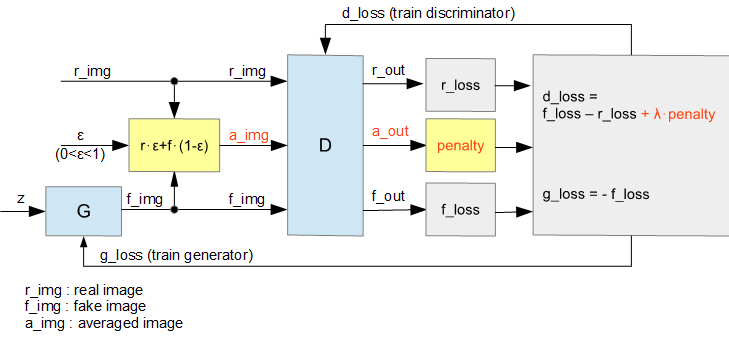